<div align="center">

# **<span>Task 4: Image Segmentation Using Clustering Methods</span>**

</div>

In [20]:
import os
import json
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy import ndimage
from skimage import measure, feature, filters

# 1. Dataset Loading

In [21]:
def load_and_preprocess_dataset(image_dir, annotation_path, num_images=50, scale_factor=16):
    with open(annotation_path, 'r') as f:
        coco_data = json.load(f)
    
    coco_images = coco_data["images"]
    coco_annotations = coco_data["annotations"] if "annotations" in coco_data else []

    image_id_to_annotations = {}
    for ann in coco_annotations:
        image_id = ann["image_id"]
        if image_id not in image_id_to_annotations:
            image_id_to_annotations[image_id] = []
        image_id_to_annotations[image_id].append(ann)
    
    filename_to_image = {img["file_name"]: img for img in coco_images}
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    valid_image_files = [f for f in image_files if f in filename_to_image]
    
    print(f"Found {len(image_files)} images in directory")
    print(f"Found {len(valid_image_files)} images with annotations")
    
    sampled_files = np.random.choice(valid_image_files, min(num_images, len(valid_image_files)), replace=False)
    
    images = []
    annotations = []
    
    for img_file in sampled_files:
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Warning: Could not load image {img_file}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        height, width = img.shape[:2]
        new_width = width // scale_factor
        new_height = height // scale_factor
        img_resized = cv2.resize(img, (new_width, new_height))
        
        images.append(img_resized)

        image_info = filename_to_image[img_file]
        image_id = image_info["id"]
        
        if image_id in image_id_to_annotations:
            annotations.append(image_id_to_annotations[image_id])
        else:
            annotations.append([])
            print(f"No annotations found for {img_file}")
    
    return images, annotations

images, annotations = load_and_preprocess_dataset(
    '/Users/sarayetel/Desktop/UT/Data Science/DataScience/CA5&6/4_Image_Segmentation_Using_Clustering_Methods/data/images', 
    '/Users/sarayetel/Desktop/UT/Data Science/DataScience/CA5&6/4_Image_Segmentation_Using_Clustering_Methods/data/annotations/instances_default.json',
    num_images=50
)

np.save("images.npy", np.array(images)) 
with open("annotations.json", "w") as f:
    json.dump(annotations, f)

print(f"Number of images: {len(images)}")
print(f"Number of annotations: {len(annotations)}")
print(f"Image array shape: {np.array(images).shape}")
print(f"Image data type: {np.array(images).dtype}")

for i, ann in enumerate(annotations[:3]):
    print(f"Image {i}: {len(ann)} annotations")
    if ann:
        print(f"  First annotation keys: {list(ann[0].keys())}")

Found 512 images in directory
Found 512 images with annotations
Number of images: 50
Number of annotations: 50
Image array shape: (50, 67, 120, 3)
Image data type: uint8
Image 0: 14 annotations
  First annotation keys: ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes']
Image 1: 14 annotations
  First annotation keys: ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes']
Image 2: 13 annotations
  First annotation keys: ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes']


In [22]:
images = np.load("images.npy", allow_pickle=True)
with open("annotations.json", "r") as f:
    annotations = json.load(f)

In [23]:
print(f"Number of images: {len(images)}")
print(f"Number of annotations: {len(annotations)}")
print(f"Image array shape: {images.shape}")
print(f"Image data type: {images.dtype}")

# Check if any annotations are None
none_count = sum(1 for ann in annotations if ann is None)
print(f"Missing annotations: {none_count}")

Number of images: 50
Number of annotations: 50
Image array shape: (50, 67, 120, 3)
Image data type: uint8
Missing annotations: 0


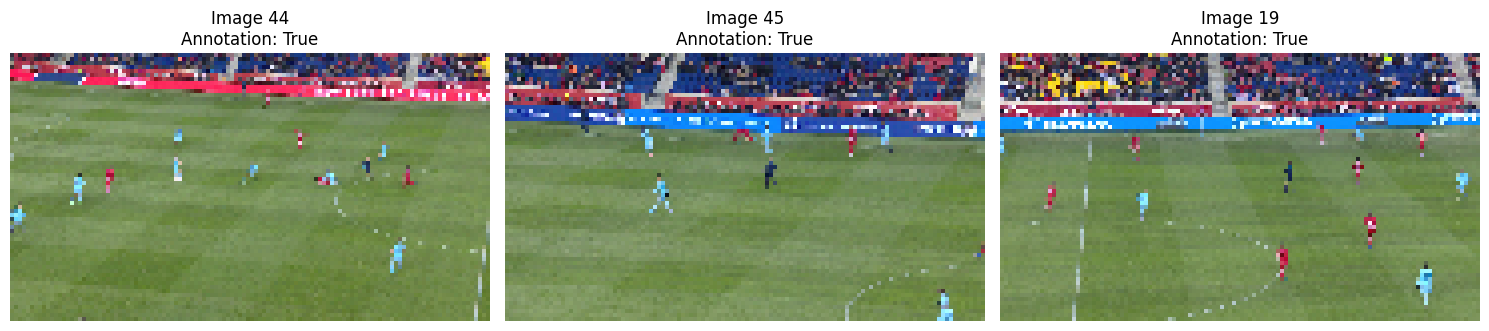

In [24]:
def visualize_sample(images, annotations, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i in range(num_samples):
        idx = random.randint(0, len(images) - 1)
        img = images[idx]
        ann = annotations[idx]
        
        axes[i].imshow(img)
        axes[i].set_title(f"Image {idx}\nAnnotation: {ann is not None}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_sample(images, annotations)

# 2. Creating Features

In [25]:
def create_advanced_features(image, method='comprehensive'):

    height, width, channels = image.shape
    pixels = image.reshape(-1, channels) / 255.0  # Normalize to [0, 1]
    
    # Position features (always included)
    x_coords = np.repeat(np.arange(width), height) / width
    y_coords = np.tile(np.arange(height), width) / height
    
    if method == 'comprehensive':
        # Color features
        color_features = pixels
        
        # Texture features using Local Binary Patterns
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        lbp = feature.local_binary_pattern(gray, 8, 1, method='uniform')
        lbp_features = lbp.reshape(-1, 1) / lbp.max()
        
        # Edge features using Sobel filters
        sobel_x = filters.sobel_v(gray)
        sobel_y = filters.sobel_h(gray)
        edge_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        edge_magnitude = edge_magnitude.reshape(-1, 1) / edge_magnitude.max()
        
        features = np.column_stack((color_features, x_coords, y_coords, 
                                    lbp_features, edge_magnitude))
        
    elif method == 'texture_rich':
        color_features = pixels
        
        # Multiple texture features
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Gabor filter responses
        gabor_filters = []
        for theta in np.arange(0, np.pi, np.pi/4):
            for sigma in (1, 3):
                for frequency in (0.05, 0.25):
                    gabor = filters.gabor(gray, frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)[0]
                    gabor_filters.append(gabor.reshape(-1, 1))
        
        # Local Binary Patterns
        lbp = feature.local_binary_pattern(gray, 8, 1, method='uniform')
        lbp_features = lbp.reshape(-1, 1) / lbp.max()
        
        texture_features = np.column_stack(gabor_filters + [lbp_features])
        features = np.column_stack((color_features, x_coords, y_coords, texture_features))
        
    elif method == 'edge_aware':
        color_features = pixels
        
        # Edge features with multiple methods
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Canny edges
        canny_edges = feature.canny(gray, sigma=1).astype(float).reshape(-1, 1)
        
        # Sobel edges
        sobel_x = filters.sobel_v(gray)
        sobel_y = filters.sobel_h(gray)
        sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2).reshape(-1, 1) / np.max(sobel_x**2 + sobel_y**2)
        
        # Laplacian edges
        laplacian = filters.laplace(gray).reshape(-1, 1) / np.max(filters.laplace(gray))
        
        edge_features = np.column_stack([canny_edges, sobel_magnitude, laplacian])
        features = np.column_stack((color_features, x_coords, y_coords, edge_features))
    
    else:
        raise ValueError(f"Unknown feature method: {method}")
    
    return features

# 3. Cluster Pixels

## 3.1 Parameter Optimization Functions

In [29]:
def find_optimal_k_elbow(features, k_range=range(2, 11), minibatch=True, sample_size=10000):
    """
    Find optimal k using elbow method (NO PLOTS)
    """
    if sample_size < len(features):
        indices = np.random.choice(len(features), sample_size, replace=False)
        sample_features = features[indices]
    else:
        sample_features = features
    
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(sample_features)
    
    inertias = []
    for k in k_range:
        if minibatch:
            km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096)
        else:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(feats_scaled)
        inertias.append(km.inertia_)
    
    # CORRECT elbow point calculation
    inertias = np.array(inertias)
    # Normalize inertias to 0-1 range for better curvature calculation
    norm_inertias = (inertias - inertias.min()) / (inertias.max() - inertias.min())
    # Calculate second derivative (curvature)
    second_derivative = np.diff(np.diff(norm_inertias))
    # Find point of maximum curvature (elbow)
    elbow_point = np.argmax(np.abs(second_derivative)) + 2  # +2 because we lost two elements
    
    optimal_k = k_range[elbow_point]
    print(f"Elbow Method: Optimal k = {optimal_k}")
    print(f"Inertia values: {inertias}")
    
    return optimal_k

def find_optimal_k_silhouette(features, k_range=range(2, 11), 
                              use_local_max=True, threshold=0.01, 
                              minibatch=True, sample_size=10000):
    """
    Find optimal k using silhouette score.
    
    Parameters:
    -----------
    features : ndarray
        Feature matrix (n_samples x n_features).
    k_range : range
        Range of k values to test.
    use_local_max : bool
        If True, choose the first local maximum instead of the global maximum.
    threshold : float
        Minimum improvement needed to continue increasing k 
        (used only if use_local_max=True).
    minibatch : bool
        If True, use MiniBatchKMeans for speed.
    sample_size : int
        Number of samples to use for MiniBatchKMeans.
    """

    # Standardize
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(features)

    scores = []
    for k in k_range:
        if minibatch:
            km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096)
        else:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(feats_scaled)
        score = silhouette_score(feats_scaled, labels)
        scores.append(score)

    scores = np.array(scores)

    if use_local_max:
        # Pick first local maximum
        best_k = k_range[0]
        for i in range(1, len(scores)):
            if scores[i] < scores[i-1] + threshold:  # improvement small
                best_k = k_range[i-1]
                break
        else:
            best_k = k_range[np.argmax(scores)]
    else:
        # Pick global maximum
        best_k = k_range[np.argmax(scores)]

    print(f"Silhouette Method: Optimal k = {best_k}")
    print(f"Scores: {dict(zip(k_range, scores))}")

    return best_k

def find_optimal_dbscan_params(features, eps_range=np.arange(0.1, 1.0, 0.1), 
                                min_samples_range=range(5, 50, 5), sample_size=5000):
    """
    Find optimal DBSCAN parameters using silhouette score
    """
    if sample_size < len(features):
        indices = np.random.choice(len(features), sample_size, replace=False)
        sample_features = features[indices]
    else:
        sample_features = features
    
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(sample_features)
    
    best_score = -1
    best_eps = None
    best_min_samples = None
    
    # Reduce dimensionality for DBSCAN to improve performance
    pca = PCA(n_components=min(10, feats_scaled.shape[1]))
    feats_reduced = pca.fit_transform(feats_scaled)
    
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
            labels = db.fit_predict(feats_reduced)
            
            # Only calculate silhouette score if we have at least 2 clusters
            unique_labels = np.unique(labels)
            if len(unique_labels) > 1 and len(unique_labels) < sample_size/2:
                score = silhouette_score(feats_reduced, labels)
                results.append((eps, min_samples, score))
                
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples
    
    print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}, score={best_score}")
    return best_eps, best_min_samples

def find_optimal_agglomerative_params(features, n_clusters_range=range(2, 11), 
                                     linkage_types=['ward', 'complete', 'average', 'single'],
                                     sample_size=5000):
    """
    Find optimal Agglomerative clustering parameters using silhouette score
    """
    if sample_size < len(features):
        indices = np.random.choice(len(features), sample_size, replace=False)
        sample_features = features[indices]
    else:
        sample_features = features
    
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(sample_features)
    
    best_score = -1
    best_n_clusters = None
    best_linkage = None
    
    results = []
    
    for n_clusters in n_clusters_range:
        for linkage in linkage_types:
            # Ward linkage can only be used with Euclidean distance
            if linkage == 'ward':
                agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
            else:
                agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric='cosine')
            
            labels = agg.fit_predict(feats_scaled)
            
            # Calculate silhouette score
            if n_clusters > 1:  # Silhouette score requires at least 2 clusters
                score = silhouette_score(feats_scaled, labels)
                results.append((n_clusters, linkage, score))
                
                if score > best_score:
                    best_score = score
                    best_n_clusters = n_clusters
                    best_linkage = linkage
    
    print(f"Best Agglomerative parameters: n_clusters={best_n_clusters}, linkage={best_linkage}, score={best_score}")
    return best_n_clusters, best_linkage



## 3.2 Enhanced Clustering Wrappers

In [30]:
def run_kmeans_optimized(features, method='silhouette', minibatch=True, sample_size=10000):
    """
    Run KMeans with optimized parameters (FIXED final silhouette calculation)
    """
    # Find optimal k
    if method == 'silhouette':
        n_clusters = find_optimal_k_silhouette(features, minibatch=minibatch, sample_size=sample_size)
    else:
        n_clusters = find_optimal_k_elbow(features, minibatch=minibatch, sample_size=sample_size)
    
    print(f"Using k={n_clusters} for KMeans")
    
    # Use the SAME sample for final training as used for optimization
    if sample_size < len(features):
        indices = np.random.choice(len(features), sample_size, replace=False)
        sample_features = features[indices]
    else:
        sample_features = features
    
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(sample_features)
    
    if minibatch:
        km = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=4096)
    else:
        km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    km.fit(feats_scaled)
    labels = km.labels_
    
    # Calculate final silhouette score on the SAME data
    if n_clusters > 1:
        score = silhouette_score(feats_scaled, labels)
        print(f"Final Silhouette Score: {score:.4f} (on optimization sample)")
    
    # Now fit on full dataset for final model
    feats_full_scaled = scaler.transform(features)  # Use the same scaler
    final_labels = km.predict(feats_full_scaled)
    
    return final_labels, km, scaler, n_clusters

def run_dbscan_optimized(features, sample_size=5000):
    """
    Run DBSCAN with optimized parameters
    """
    # Find optimal parameters
    eps, min_samples = find_optimal_dbscan_params(features, sample_size=sample_size)
    
    print(f"Using eps={eps}, min_samples={min_samples} for DBSCAN")
    
    # Scaling important for mixing different feature types
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(features)
    
    # Reduce dimensionality for better performance
    pca = PCA(n_components=min(10, feats_scaled.shape[1]))
    feats_reduced = pca.fit_transform(feats_scaled)
    
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = db.fit_predict(feats_reduced)
    
    # Calculate silhouette score if possible
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1 and len(unique_labels) < len(features)/2:
        score = silhouette_score(feats_reduced, labels)
        print(f"Final Silhouette Score: {score}")
    
    return labels, db, scaler, (eps, min_samples)

def run_agglomerative_optimized(features, sample_size=5000):
    """
    Run Agglomerative clustering with optimized parameters
    """
    # Find optimal parameters
    n_clusters, linkage = find_optimal_agglomerative_params(features, sample_size=sample_size)
    
    print(f"Using n_clusters={n_clusters}, linkage={linkage} for Agglomerative Clustering")
    
    # Scaling important for mixing different feature types
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(features)
    
    if linkage == 'ward':
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    else:
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric='cosine')
    
    labels = agg.fit_predict(feats_scaled)
    
    # Calculate silhouette score
    if n_clusters > 1:
        score = silhouette_score(feats_scaled, labels)
        print(f"Final Silhouette Score: {score}")
    
    return labels, agg, scaler, (n_clusters, linkage)


## 3.3 Visualization

Loading and preparing image...
Testing on image 18 with shape (67, 120, 3)
=== COLLECTING SILHOUETTE SCORES ===


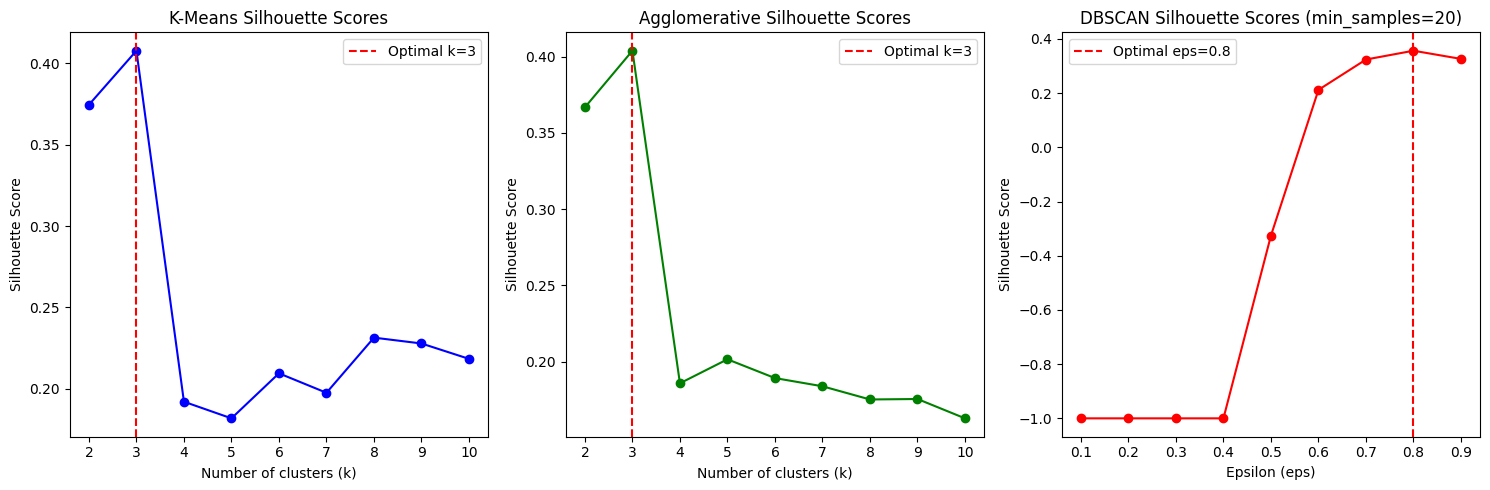


=== Running K-Means ===
Creating features...
Running kmeans clustering...
Silhouette Method: Optimal k = 3
Scores: {2: np.float64(0.37529486724247996), 3: np.float64(0.40894737439406803), 4: np.float64(0.24168368297647957), 5: np.float64(0.21972883321295858), 6: np.float64(0.22187086724849844), 7: np.float64(0.2180725566695101), 8: np.float64(0.2078487920158473), 9: np.float64(0.2107793066194741), 10: np.float64(0.20838481831309147)}
Using k=3 for KMeans
Final Silhouette Score: 0.3994 (on optimization sample)

=== Running DBSCAN ===
Creating features...
Running dbscan clustering...
Best DBSCAN parameters: eps=0.9, min_samples=20, score=0.37686676267991787
Using eps=0.9, min_samples=20 for DBSCAN
Final Silhouette Score: 0.29524305319559974

=== Running Agglomerative ===
Creating features...
Running agglomerative clustering...
Best Agglomerative parameters: n_clusters=3, linkage=ward, score=0.405761493057771
Using n_clusters=3, linkage=ward for Agglomerative Clustering
Final Silhouette 

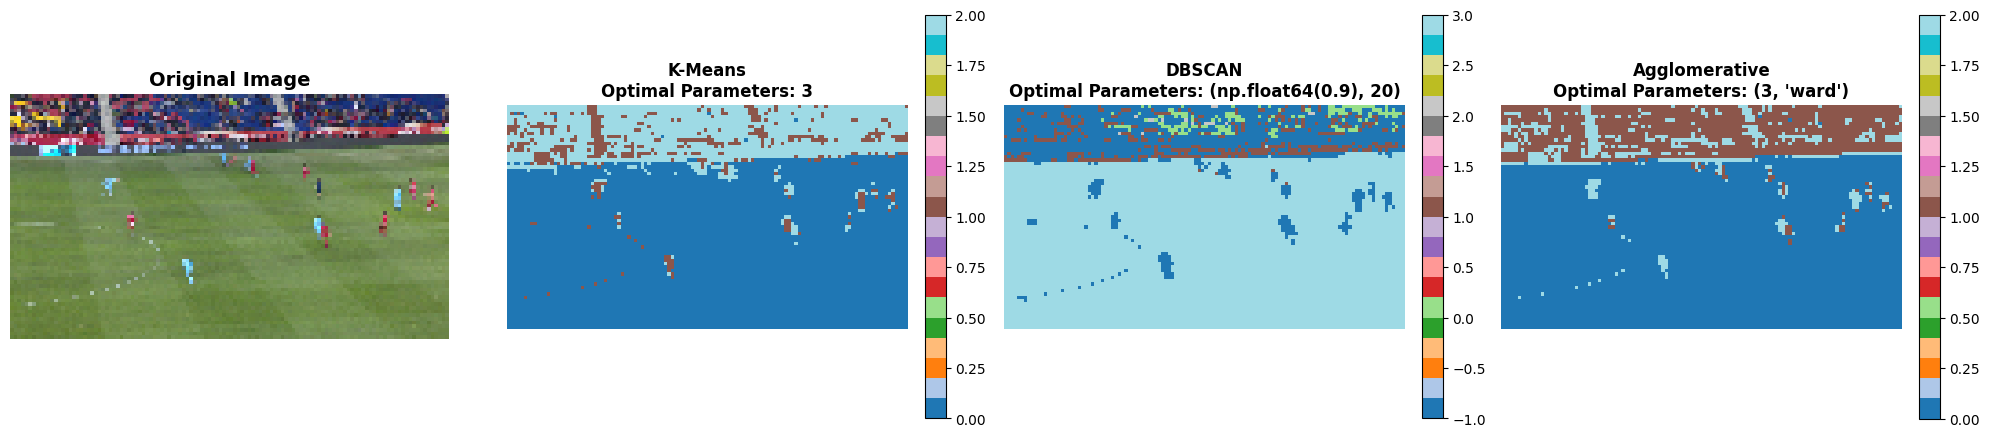


=== DETAILED RESULTS ===

K-Means:
  Optimal Parameters: 3
  Number of clusters: 3
  Cluster 0: 5837 pixels (72.6%)
  Cluster 2: 1724 pixels (21.4%)
  Cluster 1: 479 pixels (6.0%)

DBSCAN:
  Optimal Parameters: (np.float64(0.9), 20)
  Number of clusters: 4
  Noise pixels: 1541 (19.2%)
  Cluster 3: 5908 pixels (73.5%)
  Cluster 1: 408 pixels (5.1%)
  Cluster 0: 167 pixels (2.1%)
  Cluster 2: 16 pixels (0.2%)

Agglomerative:
  Optimal Parameters: (3, 'ward')
  Number of clusters: 3
  Cluster 0: 5890 pixels (73.3%)
  Cluster 1: 1534 pixels (19.1%)
  Cluster 2: 616 pixels (7.7%)


In [34]:
def collect_silhouette_scores(image, sample_size=3000):
    """
    Collect silhouette scores for all three methods and plot them
    """
    features = create_advanced_features(image, method='comprehensive')
    
    # Use the SAME preprocessing as the optimization functions
    if sample_size < len(features):
        indices = np.random.choice(len(features), sample_size, replace=False)
        sample_features = features[indices]
    else:
        sample_features = features
    
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(sample_features)
    
    # For K-Means - USE THE SAME ALGORITHM AS OPTIMIZATION
    k_range = range(2, 11)
    kmeans_scores = []
    for k in k_range:
        # Use MiniBatchKMeans like in your optimization function
        km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096)
        labels = km.fit_predict(feats_scaled)  # Use SCALED features
        if k > 1:
            score = silhouette_score(feats_scaled, labels)  # Score on SCALED features
            kmeans_scores.append(score)
        else:
            kmeans_scores.append(-1)
    
    # For Agglomerative - USE SCALED FEATURES
    agglomerative_scores = []
    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(feats_scaled)  # Use SCALED features
        if k > 1:
            score = silhouette_score(feats_scaled, labels)  # Score on SCALED features
            agglomerative_scores.append(score)
        else:
            agglomerative_scores.append(-1)
    
    # For DBSCAN - USE THE SAME PREPROCESSING AS OPTIMIZATION
    dbscan_scores = []
    eps_values = np.arange(0.1, 1.0, 0.1)
    
    # Reduce dimensionality like in your optimization function
    pca = PCA(n_components=min(10, feats_scaled.shape[1]))
    feats_reduced = pca.fit_transform(feats_scaled)
    
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=20)
        labels = db.fit_predict(feats_reduced)  # Use REDUCED features
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and len(unique_labels) < len(labels)/2:
            score = silhouette_score(feats_reduced, labels)  # Score on REDUCED features
            dbscan_scores.append(score)
        else:
            dbscan_scores.append(-1)
    
    # Plot silhouette scores
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # K-Means
    axes[0].plot(k_range, kmeans_scores, 'bo-')
    axes[0].set_xlabel('Number of clusters (k)')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_title('K-Means Silhouette Scores')
    optimal_k = k_range[np.argmax(kmeans_scores)]
    axes[0].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
    axes[0].legend()
    
    # Agglomerative
    axes[1].plot(k_range, agglomerative_scores, 'go-')
    axes[1].set_xlabel('Number of clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Agglomerative Silhouette Scores')
    optimal_k_agg = k_range[np.argmax(agglomerative_scores)]
    axes[1].axvline(x=optimal_k_agg, color='r', linestyle='--', label=f'Optimal k={optimal_k_agg}')
    axes[1].legend()
    
    # DBSCAN
    axes[2].plot(eps_values, dbscan_scores, 'ro-')
    axes[2].set_xlabel('Epsilon (eps)')
    axes[2].set_ylabel('Silhouette Score')
    axes[2].set_title('DBSCAN Silhouette Scores (min_samples=20)')
    optimal_eps = eps_values[np.argmax(dbscan_scores)]
    axes[2].axvline(x=optimal_eps, color='r', linestyle='--', label=f'Optimal eps={optimal_eps:.1f}')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'kmeans_optimal': optimal_k,
        'agglomerative_optimal': optimal_k_agg,
        'dbscan_optimal_eps': optimal_eps
    }

def cluster_image_pixels(image, clustering_method='kmeans', feature_method='comprehensive', 
                        optimize_params=True, sample_size=10000):
    """
    Main function to cluster image pixels with optimized parameters
    """
    # Create advanced features
    print("Creating features...")
    features = create_advanced_features(image, method=feature_method)
    
    # Run clustering with optimized parameters
    print(f"Running {clustering_method} clustering...")
    
    if clustering_method == 'kmeans':
        if optimize_params:
            labels, model, scaler, params = run_kmeans_optimized(
                features, method='silhouette', sample_size=sample_size)
        else:
            # You need to define run_kmeans function or handle this case
            raise NotImplementedError("run_kmeans function not defined")
            
    elif clustering_method == 'dbscan':
        if optimize_params:
            labels, model, scaler, params = run_dbscan_optimized(
                features, sample_size=sample_size)
        else:
            raise NotImplementedError("run_dbscan function not defined")
            
    elif clustering_method == 'agglomerative':
        if optimize_params:
            labels, model, scaler, params = run_agglomerative_optimized(
                features, sample_size=sample_size)
        else:
            raise NotImplementedError("run_agglomerative function not defined")
            
    else:
        raise ValueError(f"Unknown clustering method: {clustering_method}")
    
    return labels, model, scaler, params

# Modified visualization function
def visualize_all_clustering_methods(image, sample_size=3000):
    """
    Run and visualize all three clustering methods on one image
    """
    # First show silhouette scores
    print("=== COLLECTING SILHOUETTE SCORES ===")
    optimal_params = collect_silhouette_scores(image, sample_size)
    
    # Create a figure for final results
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Show original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontweight='bold', fontsize=14)
    axes[0].axis('off')
    
    methods = ['kmeans', 'dbscan', 'agglomerative']
    method_names = ['K-Means', 'DBSCAN', 'Agglomerative']
    
    results = []
    
    for i, (method, method_name) in enumerate(zip(methods, method_names), 1):
        print(f"\n=== Running {method_name} ===")
        
        try:
            # Run clustering
            labels, model, scaler, params = cluster_image_pixels(
                image, 
                clustering_method=method,
                feature_method='comprehensive',
                optimize_params=True,
                sample_size=sample_size
            )
            
            # Reshape labels to image dimensions
            segmented = labels.reshape(image.shape[:2])
            results.append((segmented, method_name, params))
            
            # Visualize colored segmentation
            im = axes[i].imshow(segmented, cmap='tab20')
            axes[i].set_title(f'{method_name}\nOptimal Parameters: {params}', 
                             fontweight='bold', fontsize=12)
            axes[i].axis('off')
            
            # Add colorbar
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
            
        except Exception as e:
            print(f"Error with {method_name}: {e}")
            axes[i].text(0.5, 0.5, f"Error:\n{str(e)}", ha='center', va='center', 
                        transform=axes[i].transAxes, fontsize=10)
            axes[i].set_title(f'{method_name}\nFailed', fontweight='bold')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Now let's run it on one of your images
print("Loading and preparing image...")

# Select a random image from your dataset
random_idx = np.random.randint(0, len(images))
test_image = images[random_idx]

print(f"Testing on image {random_idx} with shape {test_image.shape}")

# Run all clustering methods with the new visualization
results = visualize_all_clustering_methods(test_image, sample_size=3000)

# Print detailed results
print("\n=== DETAILED RESULTS ===")
for segmented, method_name, params in results:
    unique_labels = np.unique(segmented)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    print(f"\n{method_name}:")
    print(f"  Optimal Parameters: {params}")
    print(f"  Number of clusters: {n_clusters}")
    
    if -1 in unique_labels:
        noise_count = np.sum(segmented == -1)
        print(f"  Noise pixels: {noise_count} ({noise_count/segmented.size*100:.1f}%)")
    
    # Show cluster sizes for the 5 largest clusters
    cluster_sizes = []
    for label in unique_labels:
        if label != -1:
            count = np.sum(segmented == label)
            cluster_sizes.append((label, count))
    
    # Sort by size and show top 5
    cluster_sizes.sort(key=lambda x: x[1], reverse=True)
    for label, count in cluster_sizes[:5]:
        print(f"  Cluster {label}: {count} pixels ({count/segmented.size*100:.1f}%)")
    
    if len(cluster_sizes) > 5:
        print(f"  ... and {len(cluster_sizes) - 5} more clusters")

# 4. Filtering and Merging

=== APPLYING CORRECT FILTERING AND MERGING ===

Processing K-Means results...
=== FILTERING AND MERGING ===
1. Filtering clusters: removing background, keeping players...
   Removed 1 background clusters
   Kept 35 player clusters
2. Merging nearby player clusters...
   Merged 35 player clusters into 34 players


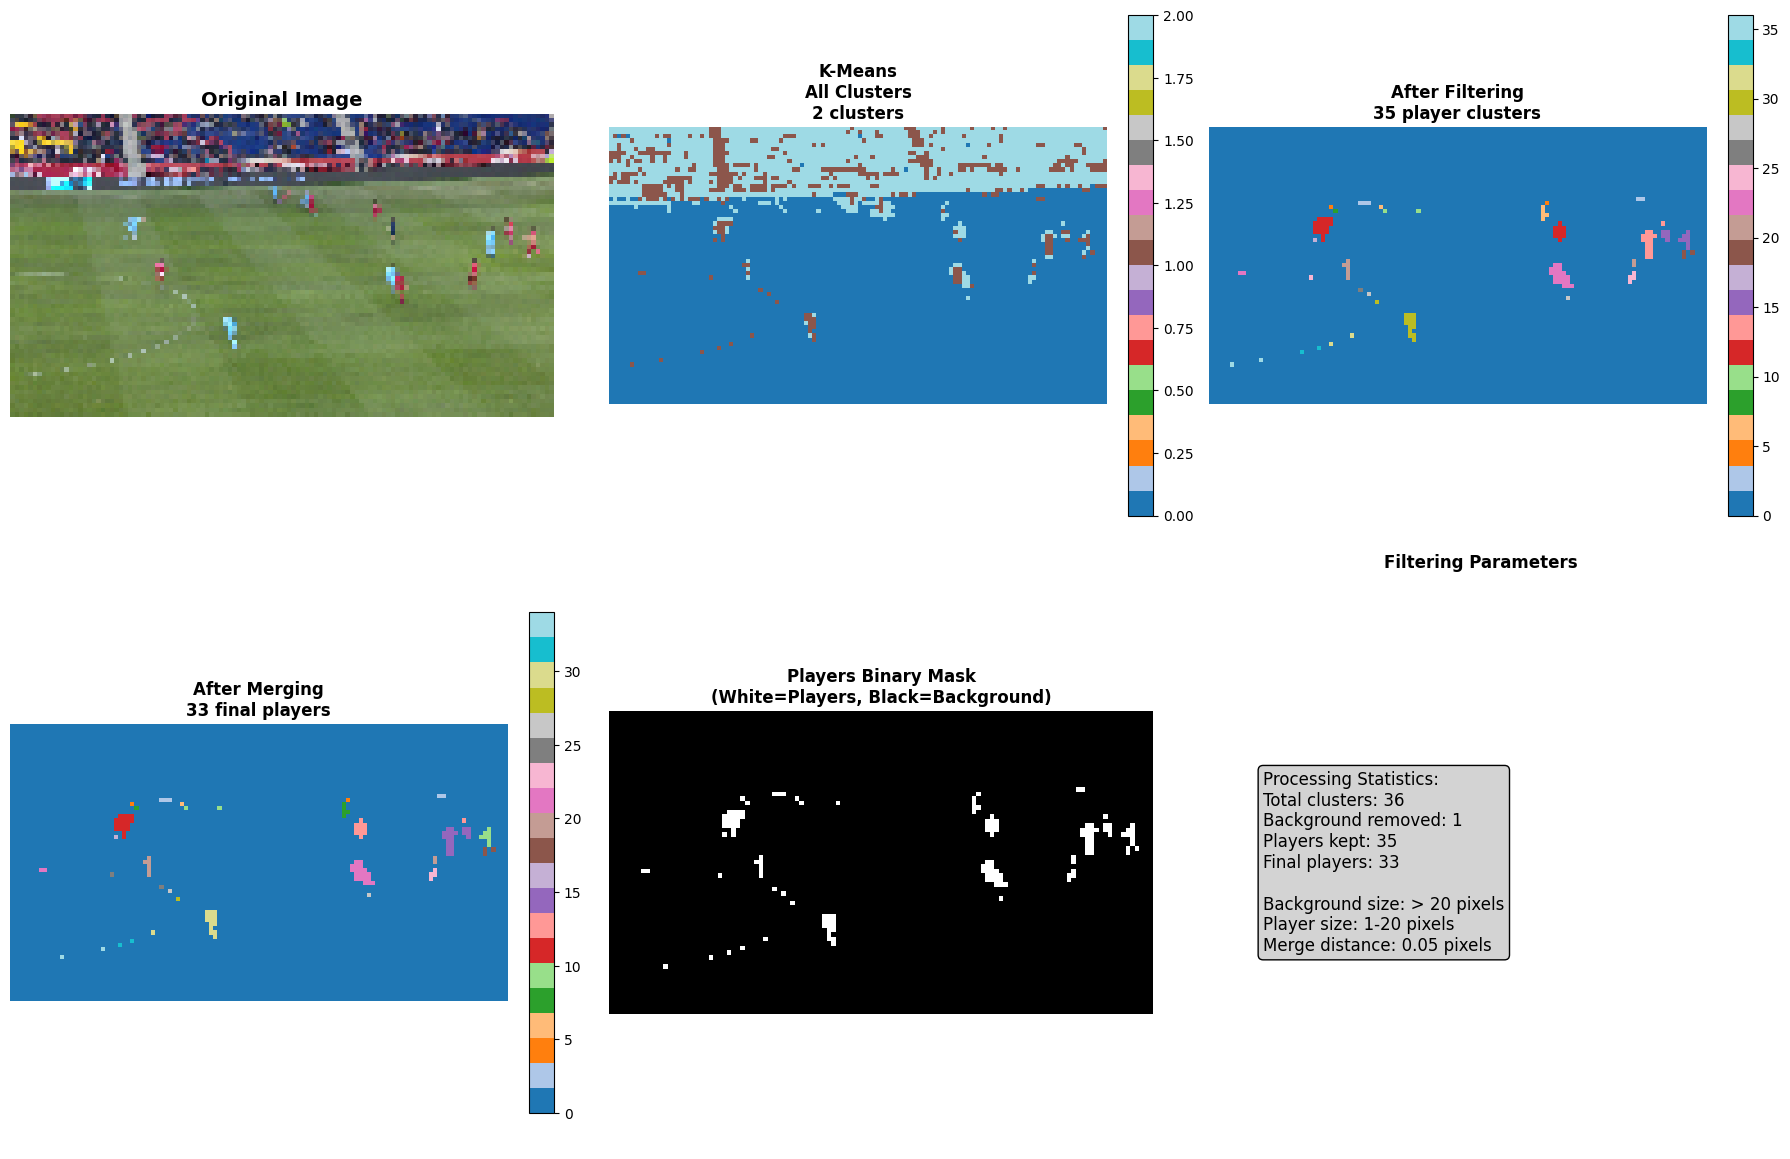

  Final players detected: 33

Processing DBSCAN results...
=== FILTERING AND MERGING ===
1. Filtering clusters: removing background, keeping players...
   Removed 2 background clusters
   Kept 115 player clusters
2. Merging nearby player clusters...
   Merged 115 player clusters into 112 players


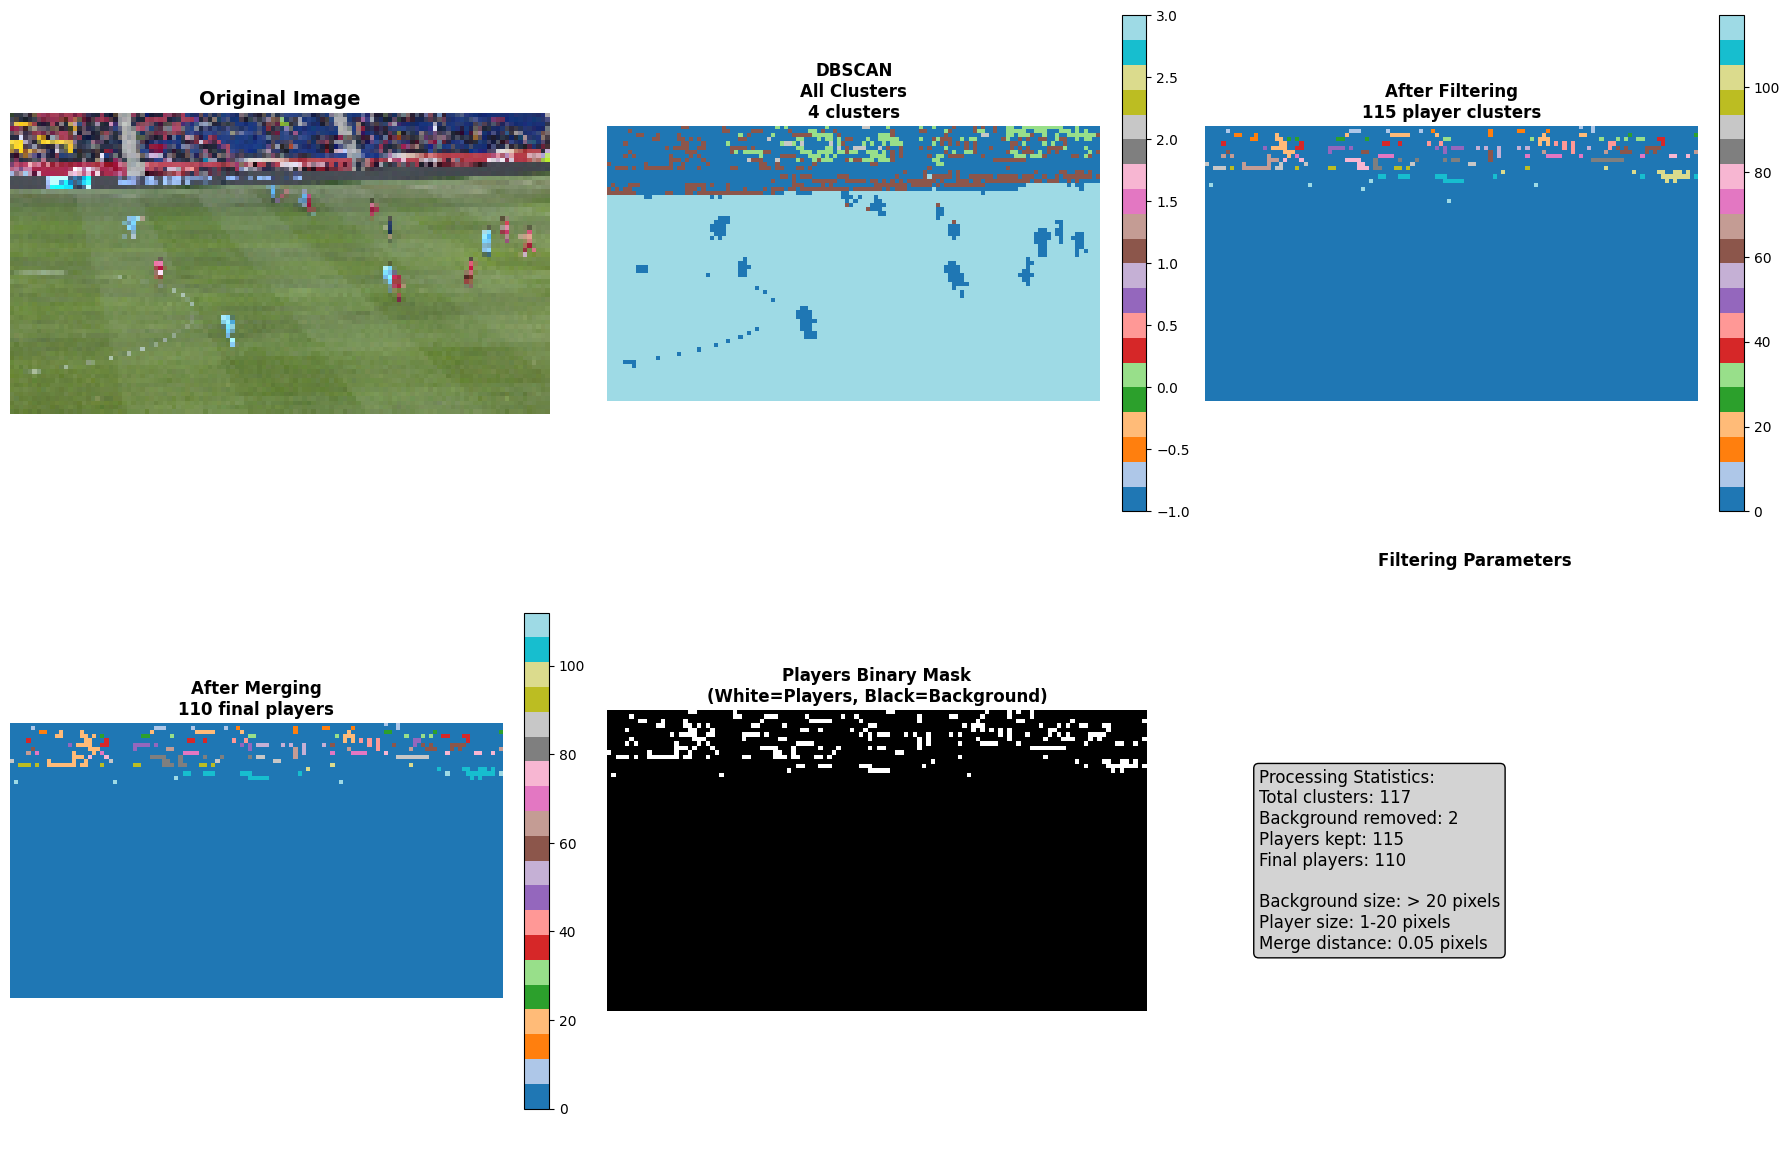

  Final players detected: 110

Processing Agglomerative results...
=== FILTERING AND MERGING ===
1. Filtering clusters: removing background, keeping players...
   Removed 1 background clusters
   Kept 25 player clusters
2. Merging nearby player clusters...
   Merged 25 player clusters into 25 players


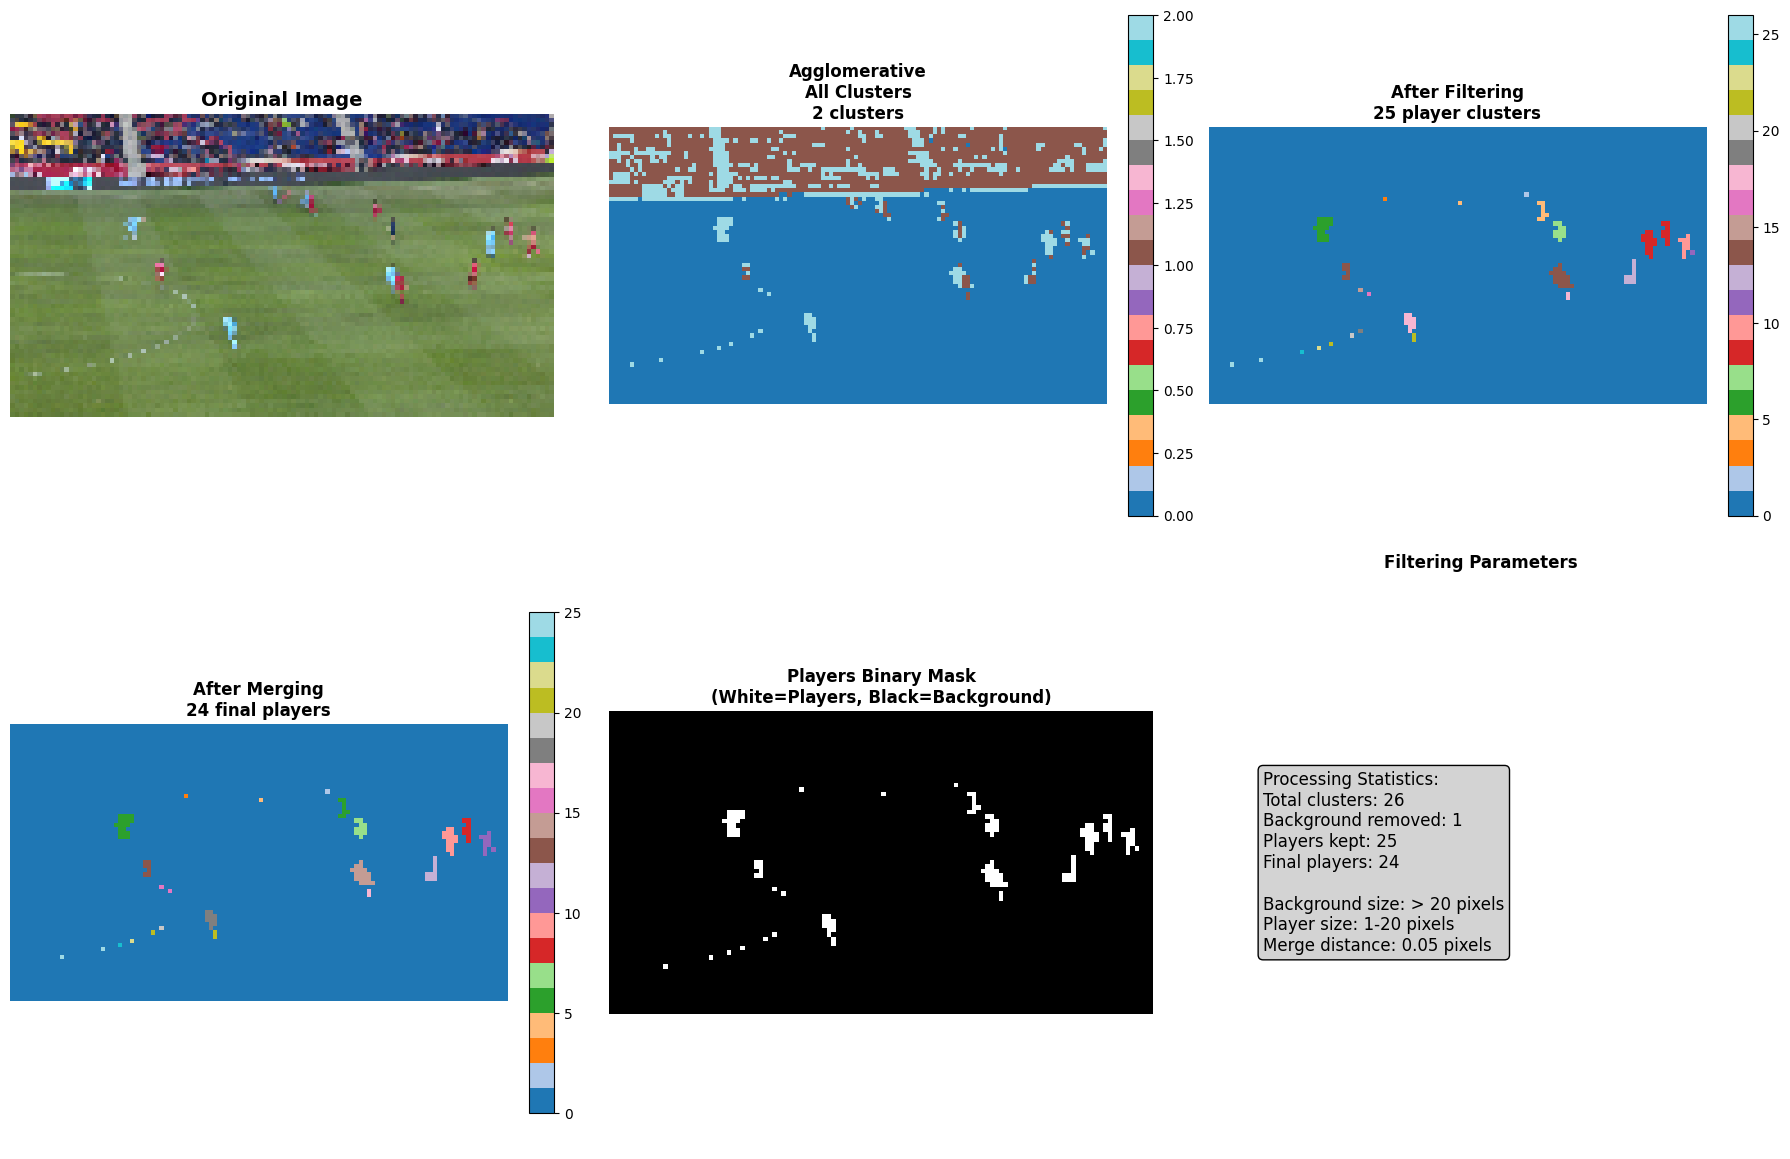

  Final players detected: 24

=== FINAL PLAYER DETECTION RESULTS ===


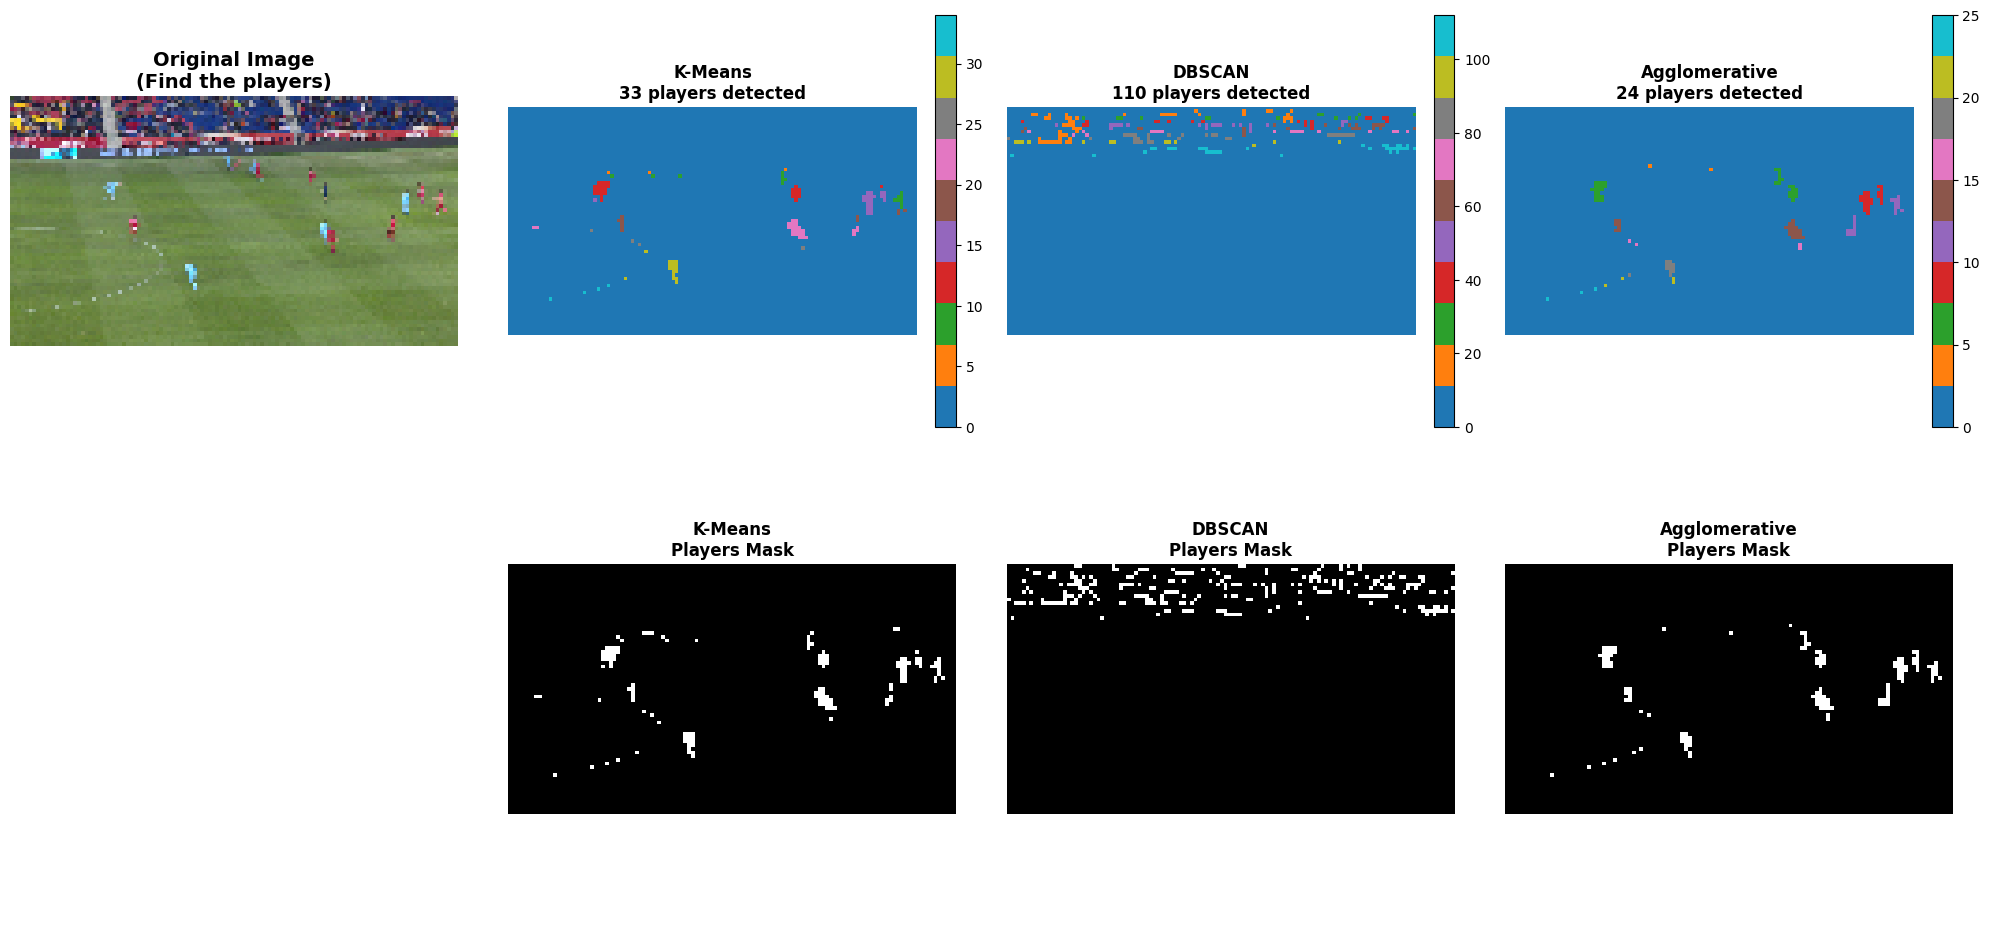


=== FINAL PLAYER DETECTION STATISTICS ===

K-Means:
  Total clusters found: 36
  Background clusters removed: 1
  Player clusters initially kept: 35
  Final players after merging: 33
  Average player cluster size: 4.0 pixels
  Player cluster sizes: [np.int64(2), np.int64(3), np.int64(1), np.int64(1), np.int64(1), np.int64(5), np.int64(1), np.int64(1), np.int64(1), np.int64(19), np.int64(11), np.int64(1), np.int64(17), np.int64(5), np.int64(8), np.int64(1), np.int64(2), np.int64(1), np.int64(6), np.int64(2), np.int64(20), np.int64(2), np.int64(4), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(15), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]

DBSCAN:
  Total clusters found: 117
  Background clusters removed: 2
  Player clusters initially kept: 115
  Final players after merging: 110
  Average player cluster size: 2.2 pixels
  Player cluster sizes: [np.int64(2), np.int64(3), np.int64(2), np.int64(1), np.int64(2), np.int64(1), n

In [48]:
# 4. Filtering and Merging Functions - CORRECTED VERSION
def filter_clusters_by_size(segmented_img, max_background_size=5000, min_player_size=50):
    """
    Filter clusters: remove large background, keep small players
    
    Parameters:
    segmented_img: clustered image (2D array of labels)
    max_background_size: maximum size for background clusters to remove (large clusters)
    min_player_size: minimum size for player clusters to keep (small clusters)
    
    Returns:
    filtered_img: image with only player clusters
    cluster_stats: dictionary with cluster statistics
    """
    # Handle DBSCAN noise (label = -1)
    if -1 in np.unique(segmented_img):
        working_img = segmented_img.copy()
        working_img[working_img == -1] = 0
    else:
        working_img = segmented_img
    
    # Label connected components
    labeled_array, num_features = ndimage.label(working_img > 0)
    
    # Calculate sizes of each component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Create mask: remove LARGE clusters (background) and keep SMALL clusters (players)
    # Also remove very small clusters (noise)
    player_mask = (component_sizes >= min_player_size) & (component_sizes <= max_background_size)
    player_mask[0] = False  # Background component (label 0)
    
    # Apply filter - KEEP only player-sized clusters, REMOVE background-sized clusters
    filtered_labels = np.zeros_like(labeled_array)
    player_clusters = []
    background_clusters = []
    
    for label in range(1, num_features + 1):
        if player_mask[label]:
            filtered_labels[labeled_array == label] = label
            player_clusters.append(label)
        else:
            background_clusters.append(label)
    
    # Collect cluster statistics
    cluster_stats = {
        'total_clusters': num_features,
        'player_clusters': len(player_clusters),
        'background_clusters': len(background_clusters),
        'player_sizes': [component_sizes[label] for label in player_clusters],
        'background_sizes': [component_sizes[label] for label in background_clusters],
        'removed_clusters': len(background_clusters)
    }
    
    return filtered_labels, cluster_stats

def merge_nearby_clusters(filtered_img, distance_threshold=20):
    """
    Merge player clusters that are close to each other (same player's body parts)
    """
    if np.max(filtered_img) == 0 or not measure.regionprops(filtered_img):
        return filtered_img, {
            'original_clusters': 0,
            'merged_clusters': 0,
            'cluster_groups': []
        }
    
    # Get region properties
    props = measure.regionprops(filtered_img)
    
    # Create adjacency matrix based on proximity
    n_clusters = len(props)
    adjacency_matrix = np.zeros((n_clusters, n_clusters), dtype=bool)
    centroids = []
    bboxes = []
    
    for i, prop in enumerate(props):
        centroids.append(prop.centroid)
        bboxes.append(prop.bbox)  # (min_row, min_col, max_row, max_col)
    
    centroids = np.array(centroids)
    
    # Calculate distances between cluster centroids AND check bounding box overlap
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            # Distance between centroids
            distance = np.sqrt(np.sum((centroids[i] - centroids[j]) ** 2))
            
            # Check if bounding boxes overlap or are very close
            bbox_i = bboxes[i]
            bbox_j = bboxes[j]
            
            # Calculate overlap/ proximity
            vertical_overlap = max(0, min(bbox_i[2], bbox_j[2]) - max(bbox_i[0], bbox_j[0]))
            horizontal_overlap = max(0, min(bbox_i[3], bbox_j[3]) - max(bbox_i[1], bbox_j[1]))
            
            # Merge if close OR overlapping
            if distance < distance_threshold or (vertical_overlap > 0 and horizontal_overlap > 0):
                adjacency_matrix[i, j] = True
                adjacency_matrix[j, i] = True
    
    # Find connected components in adjacency graph
    visited = [False] * n_clusters
    cluster_groups = []
    
    for i in range(n_clusters):
        if not visited[i]:
            group = []
            stack = [i]
            visited[i] = True
            
            while stack:
                node = stack.pop()
                group.append(node + 1)  # +1 because labels start from 1
                
                for neighbor in range(n_clusters):
                    if adjacency_matrix[node, neighbor] and not visited[neighbor]:
                        stack.append(neighbor)
                        visited[neighbor] = True
            
            cluster_groups.append(group)
    
    # Create merged image
    merged_img = np.zeros_like(filtered_img)
    merge_stats = {
        'original_clusters': n_clusters,
        'merged_clusters': len(cluster_groups),
        'cluster_groups': cluster_groups
    }
    
    for new_label, group in enumerate(cluster_groups, 1):
        for old_label in group:
            merged_img[filtered_img == old_label] = new_label
    
    return merged_img, merge_stats

def filter_and_merge_clusters(segmented_img, max_background_size=3000, min_player_size=100, distance_threshold=25):
    """
    Complete filtering and merging pipeline for football players
    
    Parameters:
    segmented_img: clustered image from any method
    max_background_size: remove clusters larger than this (background)
    min_player_size: keep clusters larger than this (players)
    distance_threshold: distance for merging nearby player clusters
    
    Returns:
    final_img: filtered and merged image with only players
    statistics: dictionary with filtering and merging stats
    """
    print("=== FILTERING AND MERGING ===")
    
    # Step 1: Filter - remove background, keep players
    print("1. Filtering clusters: removing background, keeping players...")
    filtered_img, size_stats = filter_clusters_by_size(
        segmented_img, 
        max_background_size=max_background_size,
        min_player_size=min_player_size
    )
    
    print(f"   Removed {size_stats['background_clusters']} background clusters")
    print(f"   Kept {size_stats['player_clusters']} player clusters")
    
    # Step 2: Merge nearby player clusters (body parts of same player)
    print("2. Merging nearby player clusters...")
    merged_img, merge_stats = merge_nearby_clusters(filtered_img, distance_threshold)
    
    print(f"   Merged {merge_stats['original_clusters']} player clusters into {merge_stats['merged_clusters']} players")
    
    statistics = {
        'size_filtering': size_stats,
        'merging': merge_stats,
        'final_players': len(np.unique(merged_img)) - 1  # Exclude background
    }
    
    return merged_img, statistics

def visualize_filtering_process(original_img, segmented_img, filtered_img, merged_img, 
                               method_name, stats, max_bg_size, min_player_size, distance_threshold):
    """
    Visualize the filtering and merging process
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Original image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original Image', fontweight='bold', fontsize=14)
    axes[0, 0].axis('off')
    
    # Segmented image (before filtering - shows everything)
    im1 = axes[0, 1].imshow(segmented_img, cmap='tab20')
    axes[0, 1].set_title(f'{method_name}\nAll Clusters\n{len(np.unique(segmented_img))-1} clusters', 
                        fontweight='bold', fontsize=12)
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # After filtering (only players remain)
    im2 = axes[0, 2].imshow(filtered_img, cmap='tab20')
    axes[0, 2].set_title(f'After Filtering\n{stats["size_filtering"]["player_clusters"]} player clusters', 
                        fontweight='bold', fontsize=12)
    axes[0, 2].axis('off')
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # After merging (players combined)
    im3 = axes[1, 0].imshow(merged_img, cmap='tab20')
    axes[1, 0].set_title(f'After Merging\n{stats["final_players"]} final players', 
                        fontweight='bold', fontsize=12)
    axes[1, 0].axis('off')
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # Binary mask of final result (players vs background)
    binary_mask = (merged_img > 0).astype(np.uint8)
    axes[1, 1].imshow(binary_mask, cmap='gray')
    axes[1, 1].set_title('Players Binary Mask\n(White=Players, Black=Background)', 
                        fontweight='bold', fontsize=12)
    axes[1, 1].axis('off')
    
    # Statistics text
    stats_text = f"Processing Statistics:\n"
    stats_text += f"Total clusters: {stats['size_filtering']['total_clusters']}\n"
    stats_text += f"Background removed: {stats['size_filtering']['background_clusters']}\n"
    stats_text += f"Players kept: {stats['size_filtering']['player_clusters']}\n"
    stats_text += f"Final players: {stats['final_players']}\n\n"
    stats_text += f"Background size: > {max_bg_size} pixels\n"
    stats_text += f"Player size: {min_player_size}-{max_bg_size} pixels\n"
    stats_text += f"Merge distance: {distance_threshold} pixels"
    
    axes[1, 2].text(0.1, 0.5, stats_text, fontsize=12, transform=axes[1, 2].transAxes,
                   verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[1, 2].set_title('Filtering Parameters', fontweight='bold', fontsize=12)
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Now let's apply CORRECT filtering and merging to your results
print("=== APPLYING CORRECT FILTERING AND MERGING ===")

# PARAMETERS FOR FOOTBALL PLAYER SEGMENTATION:
MAX_BACKGROUND_SIZE = 20   # Remove clusters larger than this (background/field)
MIN_PLAYER_SIZE = 1         # Keep clusters larger than this (players - adjust based on your image scale)
MERGE_DISTANCE = 0.05          # Distance for merging body parts of same player

final_results = []

for segmented, method_name, params in results:
    print(f"\nProcessing {method_name} results...")
    
    # Apply CORRECT filtering and merging
    final_img, stats = filter_and_merge_clusters(
        segmented, 
        max_background_size=MAX_BACKGROUND_SIZE,
        min_player_size=MIN_PLAYER_SIZE,
        distance_threshold=MERGE_DISTANCE
    )
    
    # Get the filtered image (before merging) for visualization
    filtered_only_img, _ = filter_clusters_by_size(
        segmented, 
        max_background_size=MAX_BACKGROUND_SIZE,
        min_player_size=MIN_PLAYER_SIZE
    )
    
    # Visualize the process
    fig = visualize_filtering_process(
        test_image, segmented, filtered_only_img, final_img, 
        method_name, stats, MAX_BACKGROUND_SIZE, MIN_PLAYER_SIZE, MERGE_DISTANCE
    )
    
    final_results.append((final_img, method_name, stats))
    
    print(f"  Final players detected: {stats['final_players']}")

# Compare final results across all methods
print("\n=== FINAL PLAYER DETECTION RESULTS ===")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Original image
axes[0, 0].imshow(test_image)
axes[0, 0].set_title('Original Image\n(Find the players)', fontweight='bold', fontsize=14)
axes[0, 0].axis('off')
axes[1, 0].axis('off')

for i, (final_img, method_name, stats) in enumerate(final_results, 1):
    # Colored final players
    im = axes[0, i].imshow(final_img, cmap='tab10')
    axes[0, i].set_title(f'{method_name}\n{stats["final_players"]} players detected', 
                        fontweight='bold', fontsize=12)
    axes[0, i].axis('off')
    plt.colorbar(im, ax=axes[0, i], fraction=0.046, pad=0.04)
    
    # Binary mask (players vs background)
    binary_mask = (final_img > 0).astype(np.uint8)
    axes[1, i].imshow(binary_mask, cmap='gray')
    axes[1, i].set_title(f'{method_name}\nPlayers Mask', fontweight='bold', fontsize=12)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Print final statistics
print("\n=== FINAL PLAYER DETECTION STATISTICS ===")
for final_img, method_name, stats in final_results:
    print(f"\n{method_name}:")
    print(f"  Total clusters found: {stats['size_filtering']['total_clusters']}")
    print(f"  Background clusters removed: {stats['size_filtering']['background_clusters']}")
    print(f"  Player clusters initially kept: {stats['size_filtering']['player_clusters']}")
    print(f"  Final players after merging: {stats['final_players']}")
    
    # Show player cluster sizes
    if stats['size_filtering']['player_sizes']:
        avg_size = np.mean(stats['size_filtering']['player_sizes'])
        print(f"  Average player cluster size: {avg_size:.1f} pixels")
        print(f"  Player cluster sizes: {stats['size_filtering']['player_sizes']}")

# 5. Even More Clustering!

In [ ]:
def create_binary_mask_and_centroids(filtered_img):
    """
    Create binary mask and compute centroids of connected components
    
    Parameters:
    filtered_img: filtered and merged cluster image
    
    Returns:
    binary_mask: binary mask where 1 represents potential players
    centroids: list of centroid coordinates for each component
    """
    # Create binary mask (non-zero values become 1)
    binary_mask = (filtered_img > 0).astype(np.uint8)
    
    # Find connected components
    labeled_mask, num_features = ndimage.label(binary_mask)
    
    # Calculate centroids
    centroids = []
    props = measure.regionprops(labeled_mask)
    
    for prop in props:
        centroids.append(prop.centroid)
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary Mask')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled_mask, cmap='nipy_spectral')
    for centroid in centroids:
        plt.plot(centroid[1], centroid[0], 'ro', markersize=5)
    plt.title('Components with Centroids')
    
    plt.tight_layout()
    plt.show()
    
    return binary_mask, centroids

# Usage example:
# binary_mask, centroids = create_binary_mask_and_centroids(filtered_img)

# 6. Evaluation

In [ ]:
def load_ground_truth_masks(annotations, image_shape):
    """
    Load ground truth masks from annotations
    
    Parameters:
    annotations: annotation data for an image
    image_shape: shape of the image (height, width)
    
    Returns:
    gt_mask: ground truth binary mask
    """
    if annotations is None:
        return np.zeros(image_shape[:2], dtype=np.uint8)
    
    height, width = image_shape[:2]
    gt_mask = np.zeros((height, width), dtype=np.uint8)
    
    # Draw polygons for each player
    for player in annotations.get('players', []):
        if 'segmentation' in player and player['segmentation']:
            # Convert polygon coordinates to image scale
            polygon = np.array(player['segmentation']).reshape(-1, 2)
            polygon[:, 0] = polygon[:, 0] * width / 1920  # Original width is 1920
            polygon[:, 1] = polygon[:, 1] * height / 1080  # Original height is 1080
            
            # Draw filled polygon
            polygon = polygon.astype(np.int32)
            cv2.fillPoly(gt_mask, [polygon], 1)
    
    return gt_mask

def calculate_iou(mask1, mask2):
    """
    Calculate Intersection over Union (IoU) between two masks
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    if union == 0:
        return 0
    
    return intersection / union

def calculate_dice(mask1, mask2):
    """
    Calculate Dice coefficient between two masks
    """
    intersection = np.logical_and(mask1, mask2).sum()
    
    if (mask1.sum() + mask2.sum()) == 0:
        return 0
    
    return 2 * intersection / (mask1.sum() + mask2.sum())

def evaluate_segmentation(images, annotations, pred_masks):
    """
    Evaluate segmentation results against ground truth
    
    Parameters:
    images: list of images
    annotations: list of annotations
    pred_masks: list of predicted binary masks
    
    Returns:
    results: DataFrame with evaluation metrics for each image
    """
    results = []
    
    for i, (img, ann, pred_mask) in enumerate(zip(images, annotations, pred_masks)):
        # Load ground truth mask
        gt_mask = load_ground_truth_masks(ann, img.shape)
        
        # Calculate metrics
        iou = calculate_iou(pred_mask, gt_mask)
        dice = calculate_dice(pred_mask, gt_mask)
        
        results.append({
            'image_id': i,
            'iou': iou,
            'dice': dice
        })
    
    return pd.DataFrame(results)

# Usage example:
# Assuming we have images, annotations, and pred_masks from previous steps
# results_df = evaluate_segmentation(images, annotations, pred_masks)
# print(results_df.mean())

# Complete Pipeline

In [ ]:
def complete_pipeline(image_dir, annotation_path, num_images=10):
    """
    Complete segmentation pipeline
    """
    # Step 1: Load and preprocess dataset
    print("Step 1: Loading and preprocessing dataset...")
    images, annotations = load_and_preprocess_dataset(image_dir, annotation_path, num_images)
    
    # Step 2: Create features
    print("Step 2: Creating features...")
    features = create_features(images, method='color_position')
    
    # Steps 3-5: Cluster, filter, and create binary masks
    pred_masks = []
    for i, (img, feat) in enumerate(zip(images, features)):
        print(f"Processing image {i+1}/{len(images)}")
        
        # Step 3: Cluster pixels
        labels = cluster_pixels(feat, method='kmeans', n_clusters=7)
        segmented_img = labels.reshape(img.shape[0], img.shape[1])
        
        # Step 4: Filter and merge clusters
        filtered_img = filter_and_merge_clusters(segmented_img, min_size=100, max_size=5000)
        
        # Step 5: Create binary mask and centroids
        binary_mask, centroids = create_binary_mask_and_centroids(filtered_img)
        pred_masks.append(binary_mask)
    
    # Step 7: Evaluation
    print("Step 7: Evaluating results...")
    results_df = evaluate_segmentation(images, annotations, pred_masks)
    
    print("Evaluation Results:")
    print(f"Mean IoU: {results_df['iou'].mean():.4f}")
    print(f"Mean Dice: {results_df['dice'].mean():.4f}")
    
    return results_df

# Usage example:
# results = complete_pipeline('path/to/images', 'path/to/annotations.json')

Questions (short answers)


1) Provide an example of a segmentation task where each type is appropriate:


- Semantic segmentation: Satellite imagery land-use classification. Each pixel
should be labeled 'water', 'forest', 'urban', etc. We don't care about
individual instances of 'tree' or 'building' — only the class matters.


- Instance segmentation: Autonomous driving pedestrian detection where you
need to separate each pedestrian as a distinct instance (for counting and
tracking). Here we need per-instance masks.


- Panoptic segmentation: Robotic scene understanding in a cluttered indoor
environment where you need both class labels for stuff (floor, wall) and
individual instance IDs for things (mug, laptop). Panoptic combines both.


2) Dice vs IoU:


- Dice = 2 * (|A ∩ B|) / (|A| + |B|) and IoU = |A ∩ B| / |A ∪ B|.
- Dice tends to be a bit more forgiving for small objects because of the
2*intersection term; IoU penalizes false positives/negatives more strictly.
- For unbalanced masks with small objects, Dice can show higher sensitivity.
IoU is stricter and often preferred for segmentation benchmarks.


3) Autoencoders for clustering images:


- Autoencoders learn a compact latent representation of input images. Train
an autoencoder on the image set; use the encoder's bottleneck outputs as
fixed-length vectors for each image. Then apply clustering (e.g., KMeans)
on these latents instead of raw pixels.
- Advantages: lower dimensionality, noise suppression, features are learned
to capture useful structure. This dramatically speeds up clustering and
yields better cluster separation than clustering on raw pixels or high-dim
vectors.